## 변동사항

* 장성민 데이터의 클래스 컬럼을 각각 category취급하여 str로 바꿨다.
* 바꾼 데이터를 one hot 인코딩하여 모델에 적합한 데이터로 바꿨다.
* conv1d multi 모델에 교수님(대,중,소) 데이터와 장성민 데이터를 넣고 학습시켰다.
* relu를 이용해보았으나 elu보다는 성능차이가 컸음 -> 그대로 elu를 이용하였습니다.
* train loss의 감소폭이 커서 전보다 성능이 좋아졌다고 할 수 있습니다.
* validation_loss의 감소는 크지않아 validation 감소의 개선여지가 큽니다.
* 마지막 예측에 각 데이터를 예측하여 제출하였습니다.

In [210]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow import set_random_seed
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.preprocessing.text import *

In [211]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()


In [212]:
train = pd.read_csv('X_train_after_corr.csv',encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
test = pd.read_csv('X_test_after_corr.csv', encoding='cp949')

In [213]:
#df_train.goods_id.nunique(), df_train.gds_grp_nm.nunique(), df_train.gds_grp_mclas_nm.nunique()
#df_train.store_nm.astype('category').cat.codes
#pd.to_datetime(df_train.tran_date).dt.weekday

max_features = 100000
max_len = 100
emb_dim = 128

In [214]:
train['class']=train['class'].apply(lambda x:str(x))
test['class']=test['class'].apply(lambda x: str(x))
# Converts a "goods_id" to a sequence of indexes in a fixed-size hashing space

train = train.groupby('cust_id')['class'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
test = test.groupby('cust_id')['class'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_cla = sequence.pad_sequences(train, maxlen=max_len)
X_test_cla = sequence.pad_sequences(test, maxlen=max_len)

X_train_cla.shape,X_test_cla.shape

((3500, 100), (2482, 100))

In [215]:
# Converts a "goods_id" to a sequence of indexes in a fixed-size hashing space
df_train.goods_id = df_train.goods_id.apply(lambda x: str(x))
df_test.goods_id = df_test.goods_id.apply(lambda x: str(x))
X_train = df_train.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_low = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_low = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_low.shape, X_test_low.shape

((3500, 100), (2482, 100))

In [216]:
# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values

# Pads sequences to the same length
X_train_mid = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_mid = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_mid.shape, X_test_mid.shape

((3500, 100), (2482, 100))

In [217]:
# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_high = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_high.shape, X_test_high.shape

((3500, 100), (2482, 100))

In [218]:
# Converts a "store_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['store_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['store_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_str = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_str = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_str.shape, X_test_str.shape

((3500, 100), (2482, 100))

In [219]:
# Converts a "tran_date" to a sequence of indexes in a fixed-size hashing space
df_train.tran_date = pd.to_datetime(df_train.tran_date).dt.weekday
df_test.tran_date = pd.to_datetime(df_test.tran_date).dt.weekday
X_train = df_train.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values
X_test = df_test.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values

# Pads sequences to the same length
X_train_day = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_day = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_day.shape, X_test_day.shape

((3500, 100), (2482, 100))

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cla (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
low (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
mid (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
high (InputLayer)               (None, 100)          0                                            
___________________________________________________________________________________________

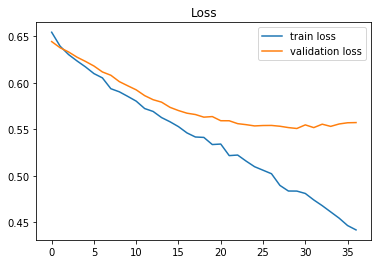

In [220]:
# Define the Model & its Architecture
in_cla = Input(shape=(max_len,), dtype='int32', name='cla')
x = Embedding(max_features, emb_dim)(in_cla)
x = Conv1D(32, 5, activation='elu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_cla = Dropout(0.5)(x)

in_low = Input(shape=(max_len,), dtype='int32', name='low')
x = Embedding(max_features, emb_dim)(in_low)
x = Conv1D(32, 5, activation='elu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_low = Dropout(0.5)(x)

in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
x = Embedding(max_features//10, emb_dim)(in_mid)
x = Conv1D(32, 3, activation='elu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 3, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_mid = Dropout(0.5)(x)

in_high = Input(shape=(max_len,), dtype='int32', name='high')
x = Embedding(max_features//100, emb_dim)(in_high)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_high = Dropout(0.5)(x)

in_str = Input(shape=(max_len,), dtype='int32', name='store')
x = Embedding(max_features//100, emb_dim)(in_str)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_str = Dropout(0.5)(x)

in_day = Input(shape=(max_len,), dtype='int32', name='day')
x = Embedding(7, emb_dim)(in_day)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_day = Dropout(0.5)(x)

x = add([out_cla,out_low, out_mid, out_high, out_str, out_day], name='my_layer')
out = Dense(1, activation='sigmoid')(x)

model = Model([in_cla,in_low, in_mid, in_high, in_str, in_day], out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit([X_train_cla,X_train_low, X_train_mid, X_train_high, X_train_str, X_train_day], y_train, epochs=50, batch_size=64, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=7)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [223]:
pred = model.predict([X_test_cla,X_test_low, X_test_mid, X_test_high, X_test_str, X_test_day])[:,0]
fname = '서진영_6.csv'
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'서진영_6.csv' is ready to submit.
